In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from tqdm import trange

In [11]:
ivi=[2.6*0.28,3.43*0.31,4.8*0.33,7.7*0.32,11.4*0.37,16.7*0.36,27.8*0.32,45.9*0.25,67.8*0.18]
kinopoisk=[0,0,0,0,0,0,27.8*0.08,45.9*0.19,67.8*0.23]

overall=np.array(ivi)/399+np.array(kinopoisk)/299

In [12]:
clientelle=overall*1000000/40
clientelle

array([  45.61403509,   66.62280702,   99.2481203 ,  154.38596491,
        264.28571429,  376.69172932,  743.34666097, 1448.16556441,
       2068.50780798])

In [13]:
class Agent:
    def __init__(self,idx,kprice=299,iprice=399):
        self.idx=idx
        self.client=False
        self.kinopoiskclient=False
        self.iviclient=False
        self.alpha=2.62
        self.alpha1=2.7
        self.alpha2=3
        self.beta=0.005
        self.gamma=1.5
        self.u0=self.alpha-self.gamma
        self.kinopoiskprice=kprice
        self.iviprice=iprice
        self.ac1=np.power(self.kinopoiskprice/self.iviprice,1/5)
        self.ac2=np.power(self.iviprice/self.kinopoiskprice,1/5)
        self.u1=np.float64(self.alpha1-self.iviprice*self.beta)
        self.u2=np.float64(self.alpha2-self.kinopoiskprice*self.beta)
    def turn(self):
        self.client=True
        self.iviclient=True
    def adopt(self,kinopoisk,iviratio,kinopoiskratio):
        self.client=True
        
        if kinopoisk==True:
            # pirate utility
            u0=self.u0
            # ivi utility
            u1=self.u1+self.ac1*iviratio
            # kinopoisk utility
            u2=self.u2+self.ac2*kinopoiskratio
            p0=np.exp(u0)/(np.exp(u0)+np.exp(u1)+np.exp(u2))
            p1=np.exp(u1)/(np.exp(u0)+np.exp(u1)+np.exp(u2))
            p2=np.exp(u2)/(np.exp(u0)+np.exp(u1)+np.exp(u2))
            self.choice=np.random.choice([0,1,2],p=[p0,p1,p2])
            if self.choice==0:
                self.client=False
                self.kinopoiskclient=False
                self.iviclient=False
            elif self.choice==1:
                self.client=True
                self.kinopoiskclient=False
                self.iviclient=True
            elif self.choice==2:
                self.client=True
                self.kinopoiskclient=True
                self.iviclient=False
        else:
            u0=self.u0
            u1=self.u1
            p0=np.exp(u0)/(np.exp(u0)+np.exp(u1))
            p1=np.exp(u1)/(np.exp(u0)+np.exp(u1))
            self.choice=np.random.choice([0,1],p=[p0,p1])
            if self.choice==0:
                self.client=False
                self.iviclient=False
            elif self.choice==1:
                self.client=True
                self.iviclient=True

In [14]:
def advancedsim(p=0.0025,q=0.05,numagents=200,firstclients=2,kprice=299,iprice=399):
    agentlist=[]
    clientssum=[firstclients]
    periods=216
    iviclients=[firstclients]
    kinopoiskclients=[0]
    for i in range(numagents):
        agent=Agent(i,kprice,iprice)
        agentlist.append(agent)
    for i in range(firstclients):
        agentlist[i].turn()
    for t in range(periods):
        
        if t==0:
            continue
        if t//12>=6:
            kinopoisk=True
        else:
            kinopoisk=False
        sumclients=np.sum([agent.client for agent in agentlist])
        for agent in agentlist:
            if np.random.uniform(0,1)<p+q*sumclients/numagents:
                agent.adopt(kinopoisk,
                            sum([agent.iviclient for agent in agentlist])/sumclients,
                            sum([agent.kinopoiskclient for agent in agentlist])/sumclients)
        clientssum.append(np.sum([agent.client for agent in agentlist]))
        kinopoiskclients.append(sum([agent.kinopoiskclient for agent in agentlist]))
        iviclients.append(sum([agent.iviclient for agent in agentlist]))
    overallprofit=0
    overallkinopoiskclients=0
    overalliviclients=0
    clientyear=[]
    kinopoiskclientsyear=[]
    iviclientsyear=[]
    for idx,(profit,kinopoisk,ivi) in enumerate(zip(clientssum,kinopoiskclients,iviclients)):
        overallprofit+=profit
        overallkinopoiskclients+=kinopoisk
        overalliviclients+=ivi
        if idx%12==11:
            kinopoiskclientsyear.append(overallkinopoiskclients)
            iviclientsyear.append(overalliviclients)
            clientyear.append(overallprofit)
            overallprofit=0
            overallkinopoiskclients=0
            overalliviclients=0
    return clientyear,kinopoiskclientsyear,iviclientsyear

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:07<00:00,  1.49it/s]

0.9967990918997749


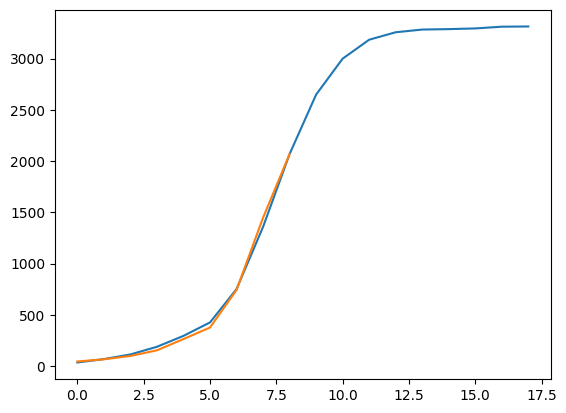

In [15]:
np.random.seed(42)
simres=[advancedsim(p=0.0005,q=0.1,numagents=340,kprice=299,iprice=399) for _ in trange(100)]
clientyear=[res[0] for res in simres]
clientyear=np.array(clientyear).mean(axis=0)
plt.plot(clientyear)
plt.plot(clientelle)
y2=np.sum((clientelle-np.mean(clientelle))**2)
yx=np.sum((np.power((clientyear[0:9]-clientelle),2)))
R2=1-yx/y2
print(R2)
kinopoiskmean=np.mean([res[1] for res in simres])
ivimean=np.mean([res[2] for res in simres])

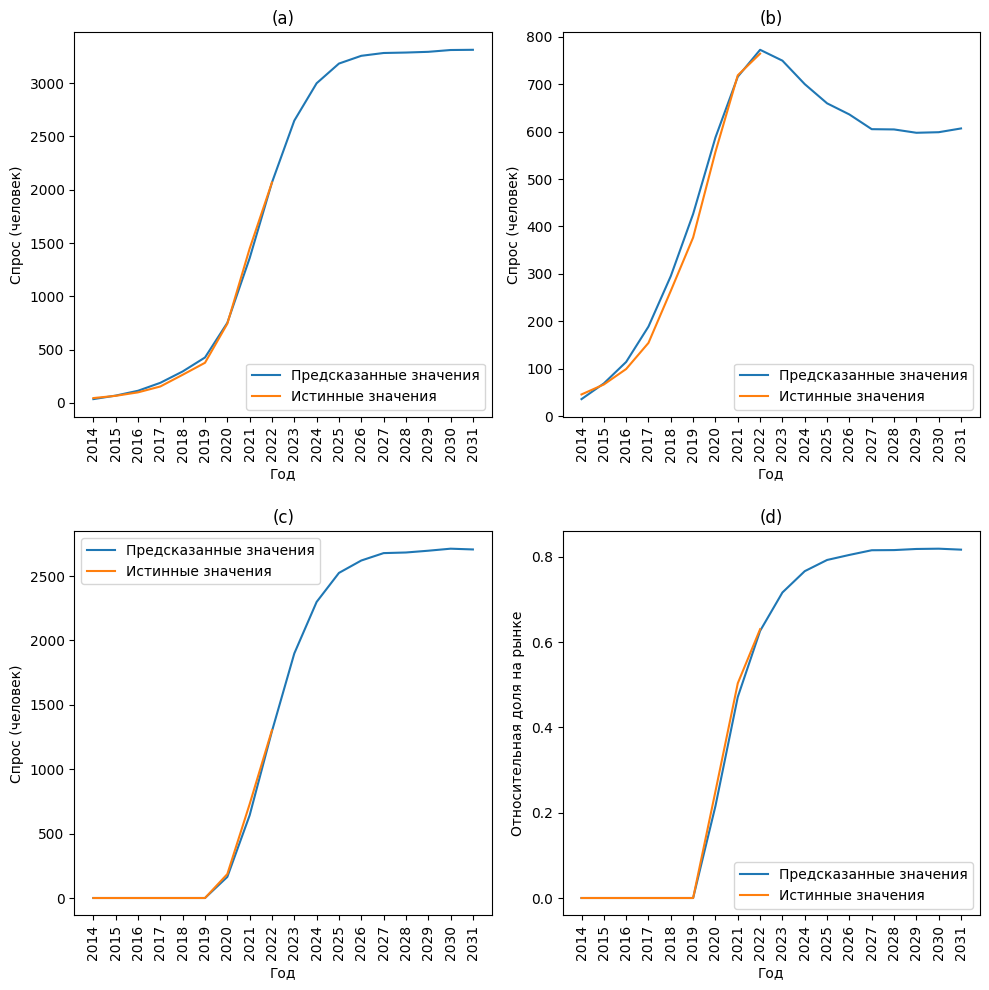

In [11]:
fig, axs = plt.subplots(2, 2,figsize=(10,10))
axs[0,0].plot(2014+np.arange(0,18),clientyear,label='Предсказанные значения')
axs[0,0].plot(2014+np.arange(0,9),clientelle,label='Истинные значения')
axs[0,0].set_xticks(2014+np.array(range(18)))
axs[0,0].set_xticklabels(2014+np.array(range(18)),rotation=90)
axs[0,0].legend()
axs[0,0].set_xlabel('Год')
axs[0,0].set_ylabel('Спрос (человек)')
axs[0,0].set_title('(a)')

axs[0,1].plot(2014+np.arange(0,18),np.array([res[2] for res in simres]).mean(axis=0),label='Предсказанные значения')
axs[0,1].plot(2014+np.arange(0,9),np.array(ivi)/399*1000000/40,label='Истинные значения')
axs[0,1].legend()
axs[0,1].set_xticks(2014+np.array(range(18)))
axs[0,1].set_xticklabels(2014+np.array(range(18)),rotation=90)
axs[0,1].set_xlabel('Год')
axs[0,1].set_ylabel('Спрос (человек)')
axs[0,1].set_title('(b)')

axs[1,0].plot(2014+np.arange(0,18),np.array([res[1] for res in simres]).mean(axis=0),label='Предсказанные значения')
axs[1,0].plot(2014+np.arange(0,9),np.array(kinopoisk)/299*1000000/40,label='Истинные значения')
axs[1,0].legend()
axs[1,0].set_xticks(2014+np.array(range(18)))
axs[1,0].set_xticklabels(2014+np.array(range(18)),rotation=90)
axs[1,0].set_xlabel('Год')
axs[1,0].set_ylabel('Спрос (человек)')
axs[1,0].set_title('(c)')

kinopoiskarray=np.array([res[1] for res in simres])/(np.array([res[1] for res in simres])+np.array([res[2] for res in simres]))
axs[1,1].plot(2014+np.arange(0,18),kinopoiskarray.mean(axis=0),label='Предсказанные значения')
axs[1,1].plot(2014+np.arange(0,9),np.array(kinopoisk)/299/overall,label='Истинные значения')
axs[1,1].legend()
axs[1,1].set_xticks(2014+np.array(range(18)))
axs[1,1].set_xticklabels(2014+np.array(range(18)),rotation=90)
axs[1,1].set_xlabel('Год')
axs[1,1].set_ylabel('Относительная доля на рынке')
axs[1,1].set_title('(d)')
plt.tight_layout(h_pad=2)
plt.savefig('baseline.png')

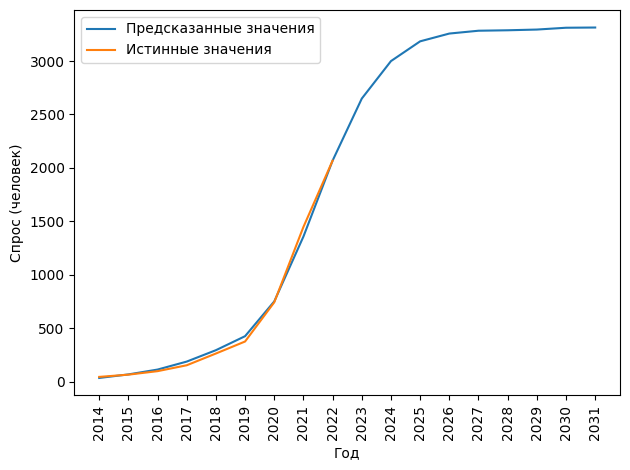

In [7]:
plt.plot(2014+np.arange(0,18),clientyear,label='Предсказанные значения')
plt.plot(2014+np.arange(0,9),clientelle,label='Истинные значения')
plt.legend()
plt.xticks(2014+np.arange(0,18),rotation=90)
plt.xlabel('Год')
plt.ylabel('Спрос (человек)')
plt.tight_layout()
plt.savefig('baselinedemand.pdf')

0.9905896103587808


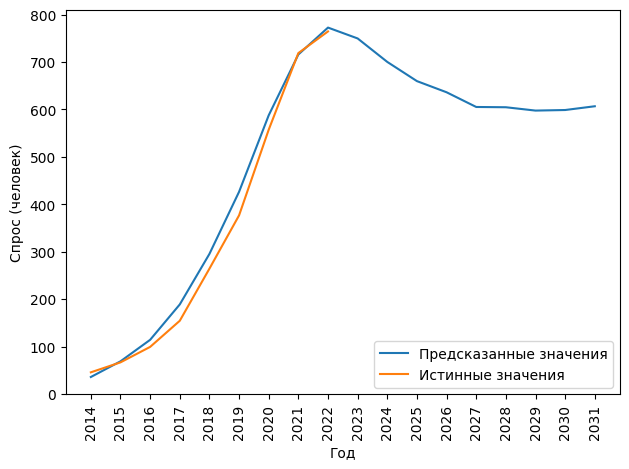

In [8]:
y2=np.sum((np.array(ivi)/399*1000000/40-np.mean(np.array(ivi)/399*1000000/40))**2)
yx=np.sum((np.power((np.array([res[2] for res in simres]).mean(axis=0)[0:9]-np.array(ivi)/399*1000000/40),2)))
R2=1-yx/y2
print(R2)
plt.plot(2014+np.arange(0,18),np.array([res[2] for res in simres]).mean(axis=0),label='Предсказанные значения')
plt.plot(2014+np.arange(0,9),np.array(ivi)/399*1000000/40,label='Истинные значения')
plt.legend()
plt.xticks(2014+np.arange(0,18),rotation=90)
plt.xlabel('Год')
plt.ylabel('Спрос (человек)')
plt.tight_layout()
plt.savefig('baselinedemandivi.pdf')

0.9952724278322908


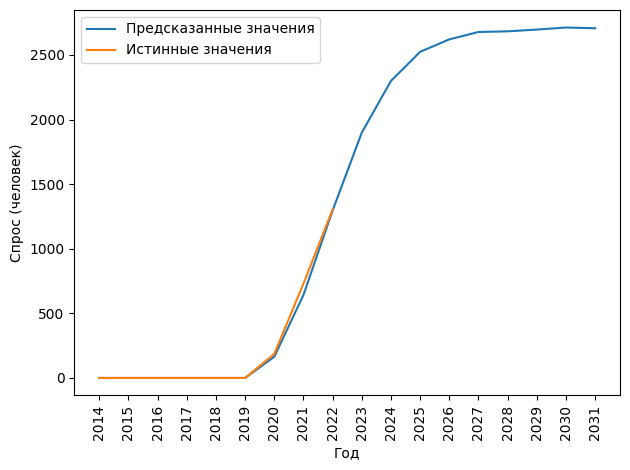

In [9]:
y2=np.sum((np.array(kinopoisk)/299*1000000/40-np.mean(np.array(kinopoisk)/299*1000000/40))**2)
yx=np.sum((np.power((np.array([res[1] for res in simres]).mean(axis=0)[0:9]-np.array(kinopoisk)/299*1000000/40),2)))
R2=1-yx/y2
print(R2)
plt.plot(2014+np.arange(0,18),np.array([res[1] for res in simres]).mean(axis=0),label='Предсказанные значения')
plt.plot(2014+np.arange(0,9),np.array(kinopoisk)/299*1000000/40,label='Истинные значения')
plt.legend()
plt.xticks(2014+np.arange(0,18),rotation=90)
plt.xlabel('Год')
plt.ylabel('Спрос (человек)')
plt.tight_layout()
plt.savefig('baselinedemandkinopoisk.pdf')

In [10]:
kinopoiskarray=np.array([res[1] for res in simres])/(np.array([res[1] for res in simres])+np.array([res[2] for res in simres]))

0.9955285825433955


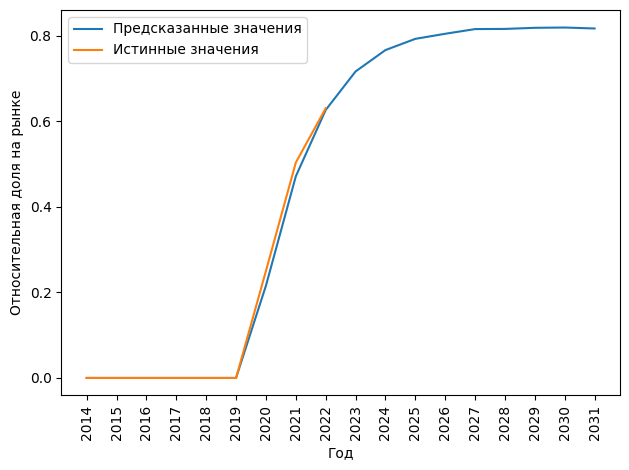

In [11]:
y2=np.sum((np.array(kinopoisk)/299/overall-np.mean(np.array(kinopoisk)/299/overall))**2)
yx=np.sum((np.power((kinopoiskarray.mean(axis=0)[0:9]-np.array(kinopoisk)/299/overall),2)))
R2=1-yx/y2
print(R2)
plt.plot(2014+np.arange(0,18),kinopoiskarray.mean(axis=0),label='Предсказанные значения')
plt.plot(2014+np.arange(0,9),np.array(kinopoisk)/299/overall,label='Истинные значения')
plt.legend()
plt.xticks(2014+np.arange(0,18),rotation=90)
plt.xlabel('Год')
plt.ylabel('Относительная доля на рынке')
plt.tight_layout()
plt.savefig('baselinesharekinopoisk.pdf')

In [17]:
np.random.seed(42)
simres2=[advancedsim(p=0.0005,q=0.1,numagents=340,kprice=299*1.05) for _ in trange(100)]
clientyear2=[res[0] for res in simres2]
clientyear2=np.array(clientyear2).mean(axis=0)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:04<00:00,  1.56it/s]


In [18]:
np.random.seed(42)
simres3=[advancedsim(p=0.0005,q=0.1,numagents=340,kprice=299*0.95) for _ in trange(100)]
clientyear3=[res[0] for res in simres3]
clientyear3=np.array(clientyear3).mean(axis=0)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:06<00:00,  1.51it/s]


In [19]:
np.random.seed(42)
simres4=[advancedsim(p=0.0005,q=0.1,numagents=340,kprice=299*0.75) for _ in trange(100)]
clientyear4=[res[0] for res in simres4]
clientyear4=np.array(clientyear4).mean(axis=0)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:08<00:00,  1.46it/s]


In [20]:
np.random.seed(42)
simres5=[advancedsim(p=0.0005,q=0.1,numagents=340,kprice=299*1.25) for _ in trange(100)]
clientyear5=[res[0] for res in simres5]
clientyear5=np.array(clientyear5).mean(axis=0)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:02<00:00,  1.59it/s]


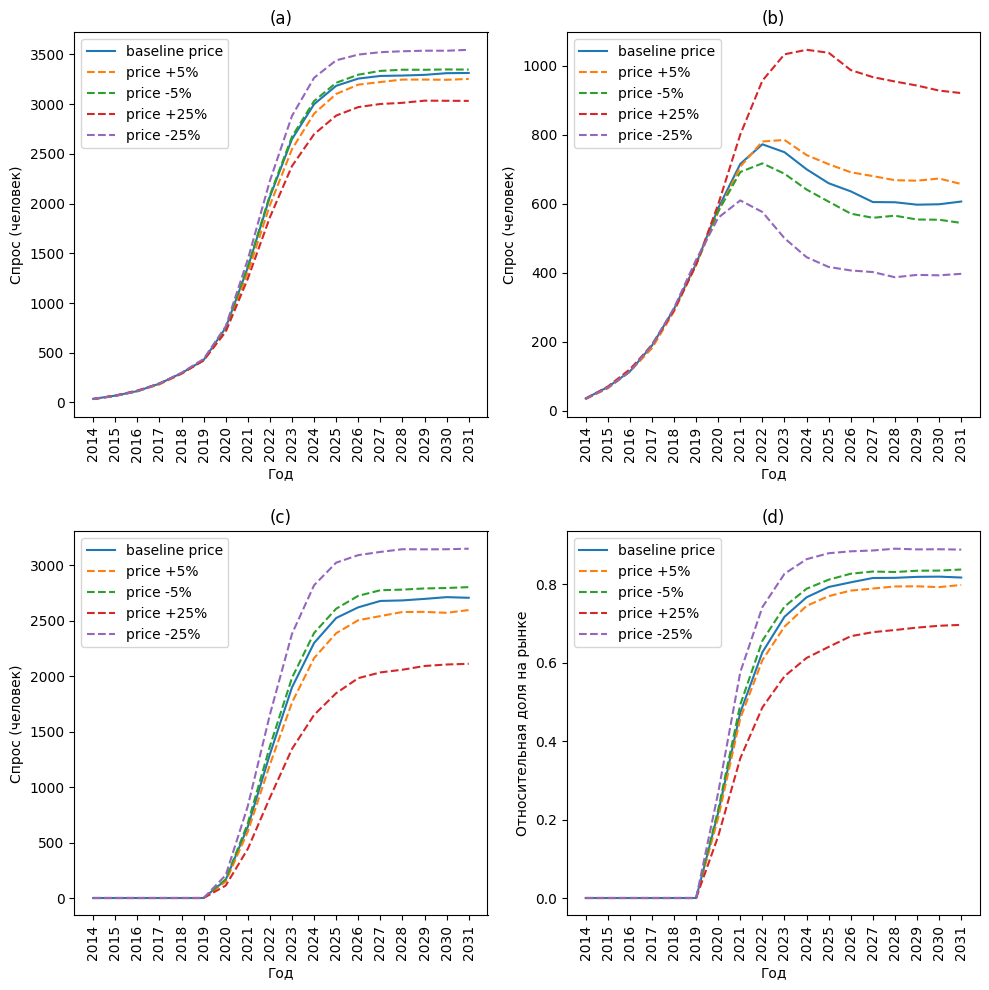

In [21]:
fig, axs = plt.subplots(2, 2,figsize=(10,10))
axs[0,0].plot(2014+np.array(range(18)),clientyear,label='baseline price')
axs[0,0].plot(2014+np.array(range(18)),clientyear2,'--',label='price +5%')
axs[0,0].plot(2014+np.array(range(18)),clientyear3,'--',label='price -5%')
axs[0,0].plot(2014+np.array(range(18)),clientyear5,'--',label='price +25%')
axs[0,0].plot(2014+np.array(range(18)),clientyear4,'--',label='price -25%')
axs[0,0].set_xticks(2014+np.array(range(18)))
axs[0,0].set_xticklabels(2014+np.array(range(18)),rotation=90)
axs[0,0].legend()
axs[0,0].set_xlabel('Год')
axs[0,0].set_ylabel('Спрос (человек)')
axs[0,0].set_title('(a)')
axs[0,1].plot(2014+np.array(range(18)),np.array([res[2] for res in simres]).mean(axis=0),label='baseline price')
axs[0,1].plot(2014+np.array(range(18)),np.array([res[2] for res in simres2]).mean(axis=0),'--',label='price +5%')
axs[0,1].plot(2014+np.array(range(18)),np.array([res[2] for res in simres3]).mean(axis=0),'--',label='price -5%')
axs[0,1].plot(2014+np.array(range(18)),np.array([res[2] for res in simres5]).mean(axis=0),'--',label='price +25%')
axs[0,1].plot(2014+np.array(range(18)),np.array([res[2] for res in simres4]).mean(axis=0),'--',label='price -25%')
axs[0,1].legend()
axs[0,1].set_xticks(2014+np.array(range(18)))
axs[0,1].set_xticklabels(2014+np.array(range(18)),rotation=90)
axs[0,1].set_xlabel('Год')
axs[0,1].set_ylabel('Спрос (человек)')
axs[0,1].set_title('(b)')
axs[1,0].plot(2014+np.array(range(18)),np.array([res[1] for res in simres]).mean(axis=0),label='baseline price')
axs[1,0].plot(2014+np.array(range(18)),np.array([res[1] for res in simres2]).mean(axis=0),'--',label='price +5%')
axs[1,0].plot(2014+np.array(range(18)),np.array([res[1] for res in simres3]).mean(axis=0),'--',label='price -5%')
axs[1,0].plot(2014+np.array(range(18)),np.array([res[1] for res in simres5]).mean(axis=0),'--',label='price +25%')
axs[1,0].plot(2014+np.array(range(18)),np.array([res[1] for res in simres4]).mean(axis=0),'--',label='price -25%')
axs[1,0].legend()
axs[1,0].set_xticks(2014+np.array(range(18)))
axs[1,0].set_xticklabels(2014+np.array(range(18)),rotation=90)
axs[1,0].set_xlabel('Год')
axs[1,0].set_ylabel('Спрос (человек)')
axs[1,0].set_title('(c)')
axs[1,1].plot(2014+np.array(range(18)),np.array([res[1] for res in simres]).mean(axis=0)/(np.array([res[1] for res in simres]).mean(axis=0)+np.array([res[2] for res in simres]).mean(axis=0)),
              label='baseline price')
axs[1,1].plot(2014+np.array(range(18)),np.array([res[1] for res in simres2]).mean(axis=0)/(np.array([res[1] for res in simres2]).mean(axis=0)+np.array([res[2] for res in simres2]).mean(axis=0)),'--',label='price +5%')
axs[1,1].plot(2014+np.array(range(18)),np.array([res[1] for res in simres3]).mean(axis=0)/(np.array([res[1] for res in simres3]).mean(axis=0)+np.array([res[2] for res in simres3]).mean(axis=0)),'--',label='price -5%')
axs[1,1].plot(2014+np.array(range(18)),np.array([res[1] for res in simres5]).mean(axis=0)/(np.array([res[1] for res in simres5]).mean(axis=0)+np.array([res[2] for res in simres5]).mean(axis=0)),'--',label='price +25%')
axs[1,1].plot(2014+np.array(range(18)),np.array([res[1] for res in simres4]).mean(axis=0)/(np.array([res[1] for res in simres4]).mean(axis=0)+np.array([res[2] for res in simres4]).mean(axis=0)),'--',label='price -25%')
axs[1,1].legend()
axs[1,1].set_xticks(2014+np.array(range(18)))
axs[1,1].set_xticklabels(2014+np.array(range(18)),rotation=90)
axs[1,1].set_xlabel('Год')
axs[1,1].set_ylabel('Относительная доля на рынке')
axs[1,1].set_title('(d)')
plt.tight_layout(h_pad=2)
plt.savefig('pricechangekinopoisk.png')

In [61]:
np.random.seed(42)
ivipotprices=[]
ivipotprofits=[]
kpotprices=[]
kpotprofits=[]
for i in range(6):
    for j in range(6):
        iprice=80+80*i
        kprice=80+80*j
        simrestemp=[advancedsim(p=0.0005,q=0.1,numagents=340,kprice=kprice,iprice=iprice) for _ in trange(100)]
        iprofit=np.sum(np.array([res[2] for res in simrestemp]).mean(axis=0)*iprice)
        kprofit=np.sum(np.array([res[1] for res in simrestemp]).mean(axis=0)*kprice)
        ivipotprices.append(iprice)
        ivipotprofits.append(iprofit)
        kpotprices.append(kprice)
        kpotprofits.append(kprofit)
        print(iprice,int(iprofit),kprice,int(kprofit))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.31it/s]


80 1885717 80 1979812


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:17<00:00,  1.29it/s]


80 2612220 160 2372043


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:15<00:00,  1.33it/s]


80 3135367 240 1993080


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.32it/s]


80 3453955 320 1550041


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:15<00:00,  1.32it/s]


80 3634224 400 1192468


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.30it/s]


80 3715800 480 920937


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:14<00:00,  1.34it/s]


160 2331563 80 2541247


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:13<00:00,  1.35it/s]


160 3408963 160 3785388


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:12<00:00,  1.38it/s]


160 4666142 240 3538689


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:14<00:00,  1.34it/s]


160 5618630 320 2821459


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:12<00:00,  1.37it/s]


160 6230798 400 2105944


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:13<00:00,  1.36it/s]


160 6549579 480 1561699


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:13<00:00,  1.36it/s]


240 2260113 80 2799684


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:12<00:00,  1.39it/s]


240 3126808 160 4660867


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:12<00:00,  1.38it/s]


240 4566220 240 5238319


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:11<00:00,  1.41it/s]


240 6243986 320 4439452


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:10<00:00,  1.43it/s]


240 7361572 400 3313548


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:10<00:00,  1.42it/s]


240 8229528 480 2428156


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:12<00:00,  1.37it/s]


320 1942118 80 2898935


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:13<00:00,  1.37it/s]


320 2612262 160 5115676


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:12<00:00,  1.38it/s]


320 3636851 240 6335056


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:07<00:00,  1.48it/s]


320 5179657 320 6225388


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:06<00:00,  1.51it/s]


320 6992518 400 4911524


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:05<00:00,  1.52it/s]


320 8407068 480 3524817


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:10<00:00,  1.42it/s]


400 1486856 80 2878251


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:09<00:00,  1.45it/s]


400 1971428 160 5256236


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:07<00:00,  1.49it/s]


400 2779060 240 6913320


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:04<00:00,  1.54it/s]


400 3927712 320 7437340


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:02<00:00,  1.61it/s]


400 5328352 400 6691128


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:00<00:00,  1.65it/s]


400 7158988 480 4954401


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:11<00:00,  1.39it/s]


480 1169174 80 2854784


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:07<00:00,  1.48it/s]


480 1531617 160 5236744


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:04<00:00,  1.55it/s]


480 2007921 240 6957379


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:03<00:00,  1.58it/s]


480 2771064 320 7957340


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:59<00:00,  1.68it/s]


480 3855825 400 7656212


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.78it/s]

480 5130499 480 6263347


In [63]:
import pandas as pd

In [65]:
l=list(zip(ivipotprofits,kpotprofits))
x = [l[x:x+6] for x in range(0, len(l), 6) ] 

In [66]:
pd.DataFrame(x,index=np.array(ivipotprices).reshape(6,6)[:,0],columns=np.array(kpotprices).reshape(6,6)[0,:]).applymap(lambda x: (int(np.round(x[0],-3)/1000),int(np.round(x[1],-3)/1000)))

,80,160,240,320,400,480
80,"(1886, 1980)","(2612, 2372)","(3135, 1993)","(3454, 1550)","(3634, 1192)","(3716, 921)"
160,"(2332, 2541)","(3409, 3785)","(4666, 3539)","(5619, 2821)","(6231, 2106)","(6550, 1562)"
240,"(2260, 2800)","(3127, 4661)","(4566, 5238)","(6244, 4439)","(7362, 3314)","(8230, 2428)"
320,"(1942, 2899)","(2612, 5116)","(3637, 6335)","(5180, 6225)","(6993, 4912)","(8407, 3525)"
400,"(1487, 2878)","(1971, 5256)","(2779, 6913)","(3928, 7437)","(5328, 6691)","(7159, 4954)"
480,"(1169, 2855)","(1532, 5237)","(2008, 6957)","(2771, 7957)","(3856, 7656)","(5130, 6263)"


In [67]:
print(pd.DataFrame(x,index=np.array(ivipotprices).reshape(6,6)[:,0],columns=np.array(kpotprices).reshape(6,6)[0,:]).applymap(lambda x: (int(np.round(x[0],-3)/1000),int(np.round(x[1],-3)/1000))).style.to_latex())

\begin{tabular}{lllllll}
 & 80 & 160 & 240 & 320 & 400 & 480 \\
80 & (1886, 1980) & (2612, 2372) & (3135, 1993) & (3454, 1550) & (3634, 1192) & (3716, 921) \\
160 & (2332, 2541) & (3409, 3785) & (4666, 3539) & (5619, 2821) & (6231, 2106) & (6550, 1562) \\
240 & (2260, 2800) & (3127, 4661) & (4566, 5238) & (6244, 4439) & (7362, 3314) & (8230, 2428) \\
320 & (1942, 2899) & (2612, 5116) & (3637, 6335) & (5180, 6225) & (6993, 4912) & (8407, 3525) \\
400 & (1487, 2878) & (1971, 5256) & (2779, 6913) & (3928, 7437) & (5328, 6691) & (7159, 4954) \\
480 & (1169, 2855) & (1532, 5237) & (2008, 6957) & (2771, 7957) & (3856, 7656) & (5130, 6263) \\
\end{tabular}

